In [1]:
import torch 
from torchvision import transforms
from PIL import Image
import time

#import torch.nn as nn
import torch.optim as optim
torch.autograd.set_detect_anomaly(True)
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

import math

import copy
from typing import Optional, List

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn, Tensor

In [2]:
def getPositionEncoding(seq_len, d, n=10000):
    convert_tensor = transforms.ToTensor()
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
            
            
    #####        
    P = np.zeros((seq_len, d))
    ####
    
    
    P=P.astype(np.float32)        
    P=convert_tensor(P) 
    return P
 



def loadgraph(train=True,run=None):
    convert_tensor = transforms.ToTensor()
    if train:
        if run==None:
            run=np.random.randint(1,11)
        else: run=run
        B=np.loadtxt('./'+str(run)+'/'+'B_padded.txt')
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A_padded.txt')
        E=np.loadtxt('./'+str(run)+'/'+'embed_padded.txt')
    else:
        if run==None:
            run=np.random.randint(11,15)
        else: run=run
        B=np.loadtxt('./'+str(run)+'/'+'B_padded.txt')
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A_padded.txt')
        E=np.loadtxt('./'+str(run)+'/'+'embed_padded.txt')
    
    E=E.astype(np.float32)
    B=B.astype(np.float32)
    A=A.astype(np.float32)
    
    
    
    E=convert_tensor(E) 
    B=convert_tensor(B) 
    A=convert_tensor(A) 
    
    
    #print('E',E.size())
    
    return E,B,A #src,tgt,y
 
    
#c = torch.randn(3, 3)
#b = torch.randn(3, 3)

#d=torch.add(b, c)

#print(c)
#print(b)
#print(d)

In [3]:
#print(stop)

class GraphTrack(nn.Module):
    def __init__(self,feature_emb,seq_length,d_m):
        super().__init__()
        self.trans=nn.Transformer(nhead=12, num_encoder_layers=6,d_model=d_m, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,batch_first=True)
        #self.cnn = nn.Sequential(
         #   torch.nn.Conv2d(ch_size, 100, kernel_size=3, stride=1, padding=1),
         #   torch.nn.ReLU())
        #self.srcpool=nn.MaxPool2d(kernel_size=3)
        #self.unflat=nn.Unflatten(1, (150, -1))
        #self.cnntgt = nn.Sequential(
        #    torch.nn.Conv2d(ch_size, ch_size, kernel_size=3, stride=1, padding=1),
        #    torch.nn.ReLU())
        #self.tgtpool=nn.MaxPool2d(kernel_size=5)
        #self.unpool = nn.MaxUnpool2d(kernel_size=5)
        
        self.pos_enc = getPositionEncoding(seq_length, d_m)
        
        self.sm = nn.Softmax(dim=2)
        
        self.lin1 = nn.Sequential(
            nn.Linear(feature_emb,d_m),
            nn.LeakyReLU())
        
        self.lin1b = nn.Sequential(
            nn.Linear(d_m,d_m),
            nn.LeakyReLU())
        
        
        self.lin2 = nn.Sequential(
            nn.Linear(seq_length,d_m),
            nn.LeakyReLU())
        
        self.lin3 = nn.Sequential(
            nn.Linear(d_m, d_m),
            nn.LeakyReLU())
        
        self.lin4 = nn.Sequential(
            nn.Linear(d_m, d_m),
            nn.LeakyReLU())
        
        self.lin4b = nn.Sequential(
            nn.Linear(d_m,seq_length),
            nn.LeakyReLU())
       
        #self.lin2b = nn.Sequential(
            #nn.Linear(10, 2))
        
        #self.lin3b = nn.Sequential(
         #   nn.Linear(12*20, 12*20),
          #  nn.LeakyReLU())
        #self.lin3c = nn.Sequential(
        #    nn.Linear(12*20, 10),
         #   nn.LeakyReLU())
       
       
        
        self.drop=nn.Dropout(0.05)
        
        
        
        
    def forward(self, src, tgt, n_nodes):
    
        
    
        src=self.lin1(src)
        src=self.drop(src)
        src=self.lin1b(src)
        
        #src=self.lin4b(src)
        #src=self.lin3(src)
        src=torch.add(src, self.pos_enc)
        #print('2',src.size())
        
        tgt = self.lin2(tgt)
        tgt = self.drop(tgt)
        tgt = self.lin3(tgt)
        tgt=torch.add(tgt, self.pos_enc)
        #tgt=tgt.flatten(u-2)
        #print('3',torch.mean(src),torch.mean(tgt))
        #src=self.lin1(src)
        #tgt=self.lin1(tgt)
        out = self.trans(src,tgt)
        #print('3',out.size())
        out=self.lin4(out)
        out=self.lin4b(out)
        
        
        out_change=out[:,:n_nodes,:n_nodes]
        
        
        
        
        out_change=sm(out_change)
        #print(A)
        z=torch.max(out_change,2)
        z=torch.outer(z.values[0], torch.ones(len(out_change[0][0])))
        #print(z)
        out_change=torch.div(out_change, z)

        
        
            
        
        
        #out=self.lin2b(out)
        #print('3',out.size())
        #out=self.unflat(out)
        #print('4',out.size())
        #out=self.unpool(out,max_indices)
        #print('5',out.size())
        return out_change

In [4]:
def train(model, optimizer, loss_function, epochs,scheduler,verbose=True,eval=True):
    
    loss_over_time = []
    test_error = []
    perf=[]
    t0 = time.time()
    i=0
    while i < epochs:
        
        u = np.random.random_integers(4998) #4998 for 3_GT
        src, tgt, y = loadgraph()
        
        optimizer.zero_grad()
        
        '''#trysimplesttrans'''
        
        #output=model(tgt,tgt)
        
        
        
        output = model(src,tgt)  
        #output = model(src)   #!!!!!!!
        #imshow(src1)
        #imshow(tgt1)
        
        
 
        #print('train_sizes',output.size(),y.size())
        
        epoch_loss = loss_function.loss(output, y)
        epoch_loss.backward()
        optimizer.step()
        scheduler.step()
        if i % 5 == 0 and i>0:
            t1 = time.time()
            epochs_per_sec = 10/(t1 - t0) 
            if verbose:
                print(f"Epoch: {i} loss {epoch_loss.item()} @ {epochs_per_sec} epochs per second")
            loss_over_time.append(epoch_loss.item())
            t0 = t1
            np.savetxt('./'+'train_loss.txt', np.c_[loss_over_time],delimiter='\t',header='trainloss')
            perf.append(epochs_per_sec)
        try:
            print(c)
            d=len(loss_over_time)
            if np.sqrt((np.mean(loss_over_time[d-10:-1])-np.mean(loss_over_time[d-20:d-10]))**2) < np.std(loss_over_time[d-10:-1])/50:
                print('loss not reducing')
                print(np.mean(loss_over_time[d-10:-1])-np.mean(loss_over_time[d-20:d-10]))
                print(np.std(loss_over_time[d-10:-1])/10)
                print(d)
                break
        except:
            pass
        
        
        
        if i % 5 == 0 and i>0:
        
    
        
            if eval:
                u = np.random.random_integers(490)
                src_t, tgt_t, y_t = loadgraph(train=False)

                output_t = model(src_t,tgt_t)

                test_loss = loss_function.loss(output_t, y_t)

                test_error.append(test_loss.item())
                
                np.savetxt('./'+'test_loss.txt', np.c_[test_error],delimiter='\t',header='testloss')

            
        
        i=i+1
            
    print('Mean Performance', np.mean(perf))
    return model, loss_over_time, test_error




def train_MSE(model, optimizer, loss_function, epochs,scheduler,verbose=True,eval=True):
    
    loss_over_time = []
    test_error = []
    perf=[]
    t0 = time.time()
    i=0
    while i < epochs:
        
        #u = np.random.random_integers(4998) #4998 for 3_GT
        src, tgt, y = loadgraph()
        
        n_nodes=0
        for h in range(len(src[0])):
            if torch.sum(src[0][h])!=0:
                n_nodes=n_nodes+1
        
        optimizer.zero_grad()
        
        '''#trysimplesttrans'''
        
        #output=model(tgt,tgt)
        
        print('nodes:',n_nodes)
        max_len=len(src[0])
        
        output = model(src,tgt,n_nodes)  
        #output = model(src)   #!!!!!!!
        #imshow(src1)
        #imshow(tgt1)
        
        

 
        print('train_sizes',src.size(),output[:,:n_nodes,:n_nodes].size(),y.size())
        
        
        epoch_loss = (max_len/n_nodes)*loss_function(output[:,:n_nodes,:n_nodes], y)
        epoch_loss.backward()
        optimizer.step()
        scheduler.step()
        if i % 5 == 0 and i>0:
            t1 = time.time()
            epochs_per_sec = 10/(t1 - t0) 
            if verbose:
                print(f"Epoch: {i} loss {epoch_loss.item()} @ {epochs_per_sec} epochs per second")
            loss_over_time.append(epoch_loss.item())
            t0 = t1
            np.savetxt('./'+'train_loss.txt', np.c_[loss_over_time],delimiter='\t',header='trainloss')
            perf.append(epochs_per_sec)
        try:
            print(c)
            d=len(loss_over_time)
            if np.sqrt((np.mean(loss_over_time[d-10:-1])-np.mean(loss_over_time[d-20:d-10]))**2) < np.std(loss_over_time[d-10:-1])/50:
                print('loss not reducing')
                print(np.mean(loss_over_time[d-10:-1])-np.mean(loss_over_time[d-20:d-10]))
                print(np.std(loss_over_time[d-10:-1])/10)
                print(d)
                break
        except:
            pass
        
        
        
        if i % 5 == 0 and i>0:
        
    
        
            if eval:
                u = np.random.random_integers(490)
                src_t, tgt_t, y_t = loadgraph(train=False)
                
                n_nodes=0
                for h in range(len(src_t[0])):
                    if torch.sum(src_t[0][h])!=0:
                        n_nodes=n_nodes+1
                
                max_len=len(src_t[0])
                
                output_t = model(src_t,tgt_t,n_nodes)

                test_loss = (max_len/n_nodes)*loss_function(output_t[:,:n_nodes,:n_nodes], y_t)

                test_error.append(test_loss.item())
                
                np.savetxt('./'+'test_loss.txt', np.c_[test_error],delimiter='\t',header='testloss')

            
        
        i=i+1
            
    print('Mean Performance', np.mean(perf))
    return model, loss_over_time, test_error


class myL_loss():
    def __init__(self,pen0,penpad):
        self.pen0 = pen0
        self.penpad = penpad
    
    def loss (self,x,y):
        print('loss')
        x=x[0]
        y=y[0]
        loss=0
        convert_tensor = transforms.ToTensor()
        for i in range(len(x)):
            for j in range(len(x)):
                l = nn.MSELoss()
                
                s = l(x[i,j], y[i,j])
                si=s.detach().numpy()
                
                #print(y[i,j])
                
                if y[i,j] == -1 and not(si<0.01):
                    s=s*self.penpad
                    
                if y[i,j] == 0 and not(si<0.0001):
                    s=s*self.pen0
                
                
                
                loss=loss+s
                
        
        return loss
    
def mean_normal(x):
    s=torch.sum(x)
    return x/s  

In [5]:
A=5*torch.rand((1,3,4))
B=A
sm=nn.Softmax(dim=2)
print(A)
A=sm(A)
#print(A)
z=torch.max(A,2)
print(z.values[0])
z=torch.outer(z.values[0], torch.ones(4))
#print(z)
A=torch.div(A, z)
print('A',A)

#print(B)

z=torch.max(B,2)
#print(z.values[0])
z=torch.outer(z.values[0], torch.ones(4))
#print(z)
B=torch.div(B, z)
print('B',B)

tensor([[[1.9591, 0.9544, 2.7689, 3.9071],
         [2.2831, 2.2466, 4.3931, 0.1732],
         [3.5635, 4.5287, 4.3652, 4.6178]]])
tensor([0.6600, 0.7982, 0.3289])
A tensor([[[0.1426, 0.0522, 0.3204, 1.0000],
         [0.1212, 0.1169, 1.0000, 0.0147],
         [0.3484, 0.9148, 0.7768, 1.0000]]])
B tensor([[[0.5014, 0.2443, 0.7087, 1.0000],
         [0.5197, 0.5114, 1.0000, 0.0394],
         [0.7717, 0.9807, 0.9453, 1.0000]]])


In [6]:
##WarmUP


#l=300
#thr=300
#ch_size=4

p_drop=0.05
learning_rate=0.01 #0.001 for cnn
epochs = 0
feature_emb=70
seq_length=104
d_m=12*20

#model = CNNTrans(ch_size,p_drop)

model = GraphTrack(feature_emb,seq_length,d_m)
#model=MiniLin(ch_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler=optim.lr_scheduler.MultiStepLR(optimizer,milestones=[15,30,50,75], gamma=1)


#loss_function = nn.MSELoss(reduction='sum')

loss_function = myL_loss(100,100)


model, loss_over_time, test_error = train(model, optimizer, loss_function, epochs, scheduler,verbose=True,eval=True)

Mean Performance nan


/home/mo/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
p_drop=0.05
learning_rate=0.0001 #0.001 for cnn
epochs = 2000
feature_emb=70
seq_length=104
d_m=12*20

#model = CNNTrans(ch_size,p_drop)


#model=MiniLin(ch_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler=optim.lr_scheduler.MultiStepLR(optimizer,milestones=[250,750,1000,1500,2000,2500], gamma=0.5)


loss_function = nn.MSELoss(reduction='sum')

#loss_function = myL_loss(100,100)


model, loss_over_time, test_error = train_MSE(model, optimizer, loss_function, epochs, scheduler,verbose=True,eval=True)

nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
Epoch: 5 loss 284.32281494140625 @ 3.278980009365602 epochs per second


/home/mo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: DeprecationWarning: This function is deprecated. Please call randint(1, 490 + 1) instead


nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55, 55])
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])
Epoch: 10 loss 205.6420440673828 @ 3.1053771179021195 epochs per second
nodes: 67
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 67, 67]) torch.Size([1, 67, 67])
nodes: 75
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 75, 75]) torch.Size([1, 75, 75])
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) to

nodes: 67
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 67, 67]) torch.Size([1, 67, 67])
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55, 55])
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55, 55])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
Epoch: 85 loss 201.46151733398438 @ 2.0792564633964856 epochs per second
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
nodes: 97
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 97, 97]) torch.Size([1, 97, 97])
nodes: 67
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 67, 67]) torch.Size([1, 67, 67])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 

Epoch: 155 loss 199.89590454101562 @ 2.399855492710295 epochs per second
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55, 55])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])
Epoch: 160 loss 195.6593017578125 @ 2.4473519050967747 epochs per second
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55, 55])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])

Epoch: 230 loss 195.72935485839844 @ 2.587135712326426 epochs per second
nodes: 67
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 67, 67]) torch.Size([1, 67, 67])
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55, 55])
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
Epoch: 235 loss 196.34962463378906 @ 2.649185248253111 epochs per second
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
nodes: 75
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 75, 75]) torch.Size([1, 75, 75])
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1

Epoch: 305 loss 196.98960876464844 @ 2.514303033442003 epochs per second
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 75
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 75, 75]) torch.Size([1, 75, 75])
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55, 55])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55, 55])
Epoch: 310 loss 196.9369659423828 @ 2.5622391442912575 epochs per second
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80,

Epoch: 380 loss 201.7510528564453 @ 2.5960769769543997 epochs per second
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
Epoch: 385 loss 200.8975830078125 @ 2.6114344521113884 epochs per second
nodes: 67
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 67, 67]) torch.Size([1, 67, 67])
nodes: 67
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 67, 67]) torch.Size([1, 67, 67])
nodes: 97
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 97, 97]) torch.Size([1, 97, 97])
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55,

Epoch: 455 loss 196.99525451660156 @ 2.5278218035285933 epochs per second
nodes: 67
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 67, 67]) torch.Size([1, 67, 67])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
nodes: 97
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 97, 97]) torch.Size([1, 97, 97])
Epoch: 460 loss 201.7267608642578 @ 2.7128482343865525 epochs per second
nodes: 97
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 97, 97]) torch.Size([1, 97, 97])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55, 55]

Epoch: 530 loss 202.18106079101562 @ 2.527035634524348 epochs per second
nodes: 75
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 75, 75]) torch.Size([1, 75, 75])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
nodes: 67
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 67, 67]) torch.Size([1, 67, 67])
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55, 55])
Epoch: 535 loss 197.02198791503906 @ 2.527581880274943 epochs per second
nodes: 75
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 75, 75]) torch.Size([1, 75, 75])
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86,

Epoch: 605 loss 199.81016540527344 @ 2.1677506529397457 epochs per second
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 75
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 75, 75]) torch.Size([1, 75, 75])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
Epoch: 610 loss 196.40066528320312 @ 2.1948527995793556 epochs per second
nodes: 75
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 75, 75]) torch.Size([1, 75, 75])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55, 55])
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104

Epoch: 680 loss 196.9379425048828 @ 2.658719063174358 epochs per second
nodes: 67
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 67, 67]) torch.Size([1, 67, 67])
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 75
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 75, 75]) torch.Size([1, 75, 75])
Epoch: 685 loss 199.82936096191406 @ 2.5630473732196237 epochs per second
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55,

Epoch: 755 loss 200.84423828125 @ 2.3940460269650274 epochs per second
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
nodes: 97
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 97, 97]) torch.Size([1, 97, 97])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
Epoch: 760 loss 200.84132385253906 @ 2.5809632374772513 epochs per second
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
nodes: 97
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 97, 97]) torch.Size([1, 97, 97])
nodes: 97
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 97, 97]) torch.Size([1, 97, 97])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 

Epoch: 830 loss 198.8541259765625 @ 2.3145689513312444 epochs per second
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 97
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 97, 97]) torch.Size([1, 97, 97])
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55, 55])
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
Epoch: 835 loss 202.1329345703125 @ 2.428697784827993 epochs per second
nodes: 75
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 75, 75]) torch.Size([1, 75, 75])
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
nodes: 75
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 75, 75]) torch.Siz

nodes: 97
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 97, 97]) torch.Size([1, 97, 97])
Epoch: 905 loss 201.6676483154297 @ 2.5673356476445823 epochs per second
nodes: 97
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 97, 97]) torch.Size([1, 97, 97])
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
nodes: 75
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 75, 75]) torch.Size([1, 75, 75])
Epoch: 910 loss 199.79808044433594 @ 2.538118487654861 epochs per second
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1

nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
Epoch: 980 loss 200.8468017578125 @ 2.4548197248787837 epochs per second
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
Epoch: 985 loss 200.84288024902344 @ 2.446724167711777 epochs per second
nodes: 97
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 97, 97]) torch.Size([1, 97, 97])
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49,

nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
Epoch: 1055 loss 199.95071411132812 @ 2.589722215310348 epochs per second
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])
nodes: 75
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 75, 75]) torch.Size([1, 75, 75])
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55, 55])
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
Epoch: 1060 loss 200.8479766845703 @ 2.5488549822431703 epochs per second
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55, 55

nodes: 67
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 67, 67]) torch.Size([1, 67, 67])
Epoch: 1130 loss 198.85935974121094 @ 2.6009666535470206 epochs per second
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55, 55])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
Epoch: 1135 loss 196.2552032470703 @ 2.5074881417081274 epochs per second
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55, 55])
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 

train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55, 55])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
Epoch: 1205 loss 196.2687530517578 @ 2.659057351976239 epochs per second
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 97
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 97, 97]) torch.Size([1, 97, 97])
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
Epoch: 1210 loss 200.8350067138672 @ 2.452258243951374 epochs per second
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
node

nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])
Epoch: 1280 loss 195.5816192626953 @ 2.7105787370575047 epochs per second
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])
Epoch: 1285 loss 195.5663604736328 @ 2.6611142192556043 epochs per second
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76

nodes: 67
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 67, 67]) torch.Size([1, 67, 67])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
Epoch: 1355 loss 200.8373260498047 @ 2.6233730980516268 epochs per second
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55, 55])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
nodes: 67
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 67, 67]) torch.Size([1, 67, 67])
nodes: 75
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 75, 75]) torch.Size([1, 75, 75])
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
Epoch: 1360 loss 200.3032989501953 @ 2.564641525299572 epochs per second
nodes: 75
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 75, 75]) torch.Size([1, 75, 75])
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104,

nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
nodes: 97
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 97, 97]) torch.Size([1, 97, 97])
Epoch: 1430 loss 201.65980529785156 @ 1.9374338299283653 epochs per second
nodes: 97
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 97, 97]) torch.Size([1, 97, 97])
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55, 55])
Epoch: 1435 loss 196.90145874023438 @ 2.54129086280084 epochs per second
nodes: 67
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 67, 67]) torch.Size([1, 67, 67])
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49

nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])
Epoch: 1505 loss 195.56150817871094 @ 2.5929514049730242 epochs per second
nodes: 75
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 75, 75]) torch.Size([1, 75, 75])
nodes: 97
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 97, 97]) torch.Size([1, 97, 97])
nodes: 75
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 75, 75]) torch.Size([1, 75, 75])
nodes: 97
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 97, 97]) torch.Size([1, 97, 97])
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
Epoch: 1510 loss 200.318115234375 @ 2.6988817118395234 epochs per second
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55, 55

nodes: 75
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 75, 75]) torch.Size([1, 75, 75])
nodes: 97
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 97, 97]) torch.Size([1, 97, 97])
Epoch: 1580 loss 201.6568145751953 @ 2.392667627049058 epochs per second
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
Epoch: 1585 loss 202.0814208984375 @ 1.935565120284992 epochs per second
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1

nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
Epoch: 1655 loss 196.23220825195312 @ 2.611570060625253 epochs per second
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
nodes: 97
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 97, 97]) torch.Size([1, 97, 97])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
nodes: 97
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 97, 97]) torch.Size([1, 97, 97])
Epoch: 1660 loss 201.64932250976562 @ 2.5687713570293584 epochs per second
nodes: 75
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 75, 75]) torch.Size([1, 75, 75])
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 4

nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])
Epoch: 1730 loss 195.54931640625 @ 2.532114899214763 epochs per second
nodes: 75
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 75, 75]) torch.Size([1, 75, 75])
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
nodes: 75
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 75, 75]) torch.Size([1, 75, 75])
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
Epoch: 1735 loss 199.92929077148438 @ 2.6712115155135256 epochs per second
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Si

train_sizes torch.Size([1, 104, 70]) torch.Size([1, 67, 67]) torch.Size([1, 67, 67])
nodes: 97
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 97, 97]) torch.Size([1, 97, 97])
nodes: 52
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 52, 52]) torch.Size([1, 52, 52])
Epoch: 1805 loss 196.25387573242188 @ 2.6522753532569654 epochs per second
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
nodes: 86
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 86, 86]) torch.Size([1, 86, 86])
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])
Epoch: 1810 loss 195.5942840576172 @ 2.6414977176380625 epochs per second
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])
nodes:

nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
Epoch: 1880 loss 199.92910766601562 @ 2.614363734359755 epochs per second
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])
nodes: 80
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 80, 80]) torch.Size([1, 80, 80])
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])
nodes: 67
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 67, 67]) torch.Size([1, 67, 67])
nodes: 75
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 75, 75]) torch.Size([1, 75, 75])
Epoch: 1885 loss 199.79379272460938 @ 2.4584570507792844 epochs per second
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 4

nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
nodes: 97
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 97, 97]) torch.Size([1, 97, 97])
Epoch: 1955 loss 201.65724182128906 @ 2.5358622564321833 epochs per second
nodes: 49
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 49, 49]) torch.Size([1, 49, 49])
nodes: 76
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 76, 76]) torch.Size([1, 76, 76])
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55, 55])
nodes: 55
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 55, 55]) torch.Size([1, 55, 55])
nodes: 104
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 104, 104]) torch.Size([1, 104, 104])
Epoch: 1960 loss 202.0946044921875 @ 2.627317144244353 epochs per second
nodes: 67
train_sizes torch.Size([1, 104, 70]) torch.Size([1, 67, 67]) torch.Size(

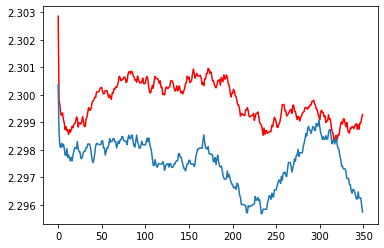

In [8]:
loss_over_time= np.loadtxt('./train_loss.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)
test_error= np.loadtxt('./test_loss.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)


N=50

plt.plot(np.convolve(np.log10(loss_over_time), np.ones(N)/N, mode='valid'),c='red')
plt.plot(np.convolve(np.log10(test_error), np.ones(N)/N, mode='valid'))

In [9]:
E,B,A = loadgraph(run=7)

output = model(E,B) 


#print(A)
#print()

out=output.detach().numpy()[0]

np.savetxt('./'+str(7)+'_GT'+'/'+'A_output.txt',out)

TypeError: forward() missing 1 required positional argument: 'n_nodes'